In [1]:
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# Inherit Layer, establish resnet18 and 34 convolutional layer modules
class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

#Inherit Model, create resnet18 and 34
class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(64, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3,3), strides=(2,2), padding='same')
        ]) #Start module

        self.layer1 = self.build_cellblock(64, layers_dims[0]) 
        self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(nb_classes, activation='softmax')
    
    def call(self, inputs, training=None):
        x=self.stem(inputs)
        # print(x.shape)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride)) #The first block stride of each layer may be non-1

        for _ in range(1, blocks):      #How many blocks each layer consists of
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks


def build_ResNet(NetName, nb_classes):
    ResNet_Config = {'ResNet18':[2,2,2,2], 
                    'ResNet34':[3,4,6,3]}

    return ResNet(ResNet_Config[NetName], nb_classes) 


model = build_ResNet('ResNet18', 1000)
model.build(input_shape=(None, 224, 224, 3))
model.summary()


    


Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 56, 56, 64)        9728      
_________________________________________________________________
sequential_1 (Sequential)    (None, 56, 56, 64)        148736    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 128)       526976    
_________________________________________________________________
sequential_3 (Sequential)    (None, 14, 14, 256)       2102528   
_________________________________________________________________
sequential_4 (Sequential)    (None, 7, 7, 512)         8399360   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5130

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [3]:
class_names = ['airplane', 'automobile', 'ship', 'truck']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [4]:
print(nb_classes)

4


In [5]:
def load_data():
    
    
    datasets = [r'CIFAR-10-images-master\train',r'CIFAR-10-images-master\test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading CIFAR-10-images-master\train


100%|██████████| 5000/5000 [00:20<00:00, 245.55it/s] 


Loading CIFAR-10-images-master\test


100%|██████████| 1000/1000 [00:06<00:00, 145.76it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0


In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

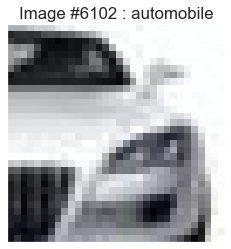

In [10]:
display_random_image(class_names, train_images, train_labels)

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

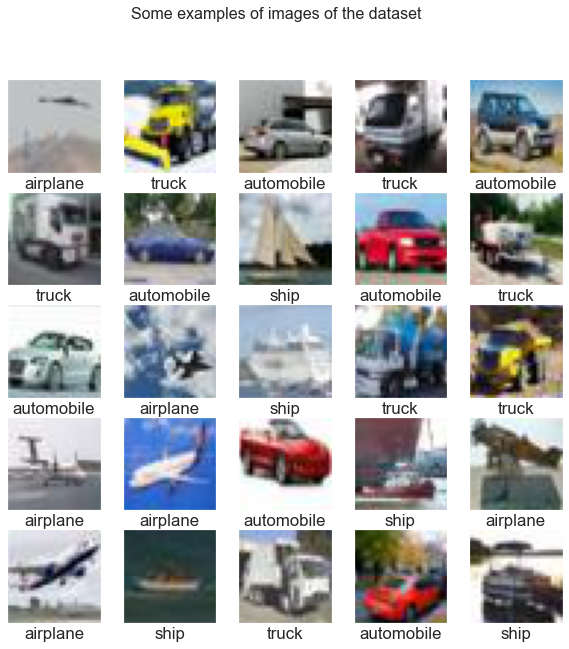

In [12]:
display_examples(class_names, train_images, train_labels)

In [13]:
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# Inherit Layer, establish resnet18 and 34 convolutional layer modules
class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

#Inherit Model, create resnet18 and 34
class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(64, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3,3), strides=(2,2), padding='same')
        ]) #Start module

        self.layer1 = self.build_cellblock(64, layers_dims[0]) 
        self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(nb_classes, activation='softmax')
    
    def call(self, inputs, training=None):
        x=self.stem(inputs)
        # print(x.shape)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride)) #The first block stride of each layer may be non-1

        for _ in range(1, blocks):      #How many blocks each layer consists of
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks


def build_ResNet(NetName, nb_classes):
    ResNet_Config = {'ResNet18':[2,2,2,2], 
                    'ResNet34':[3,4,6,3]}

    return ResNet(ResNet_Config[NetName], nb_classes) 


model = build_ResNet('ResNet18', 1000)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 56, 56, 64)        9728      
_________________________________________________________________
sequential_6 (Sequential)    (None, 56, 56, 64)        148736    
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 128)       526976    
_________________________________________________________________
sequential_8 (Sequential)    (None, 14, 14, 256)       2102528   
_________________________________________________________________
sequential_9 (Sequential)    (None, 7, 7, 512)         8399360   
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  51

In [14]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
125/125 [==============================] - 590s 5s/step - loss: 1.0112 - accuracy: 0.6274 - val_loss: 2.3124 - val_accuracy: 0.2515
Epoch 2/10
125/125 [==============================] - 577s 5s/step - loss: 0.6349 - accuracy: 0.7578 - val_loss: 3.5099 - val_accuracy: 0.3570
Epoch 3/10
125/125 [==============================] - 574s 5s/step - loss: 0.4955 - accuracy: 0.8126 - val_loss: 1.4156 - val_accuracy: 0.5285
Epoch 4/10
125/125 [==============================] - 568s 5s/step - loss: 0.4261 - accuracy: 0.8399 - val_loss: 1.1140 - val_accuracy: 0.6620
Epoch 5/10
125/125 [==============================] - 560s 4s/step - loss: 0.3398 - accuracy: 0.8726 - val_loss: 0.6015 - val_accuracy: 0.7940
Epoch 6/10
125/125 [==============================] - 568s 5s/step - loss: 0.2924 - accuracy: 0.8923 - val_loss: 0.6309 - val_accuracy: 0.7905
Epoch 7/10
125/125 [==============================] - 567s 5s/step - loss: 0.2423 - accuracy: 0.9106 - val_loss: 0.9800 - val_accuracy: 0.7235

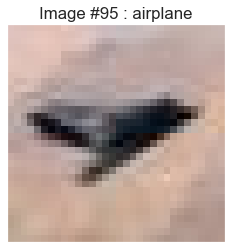

In [17]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)